<a href="https://colab.research.google.com/github/dave502/NLP/blob/main/lesson_04/nlp_hw_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%%capture
!pip install pymorphy2
!pip install stop_words
!pip install pyLDAvis

In [8]:
import pandas  as pd
import numpy as np
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation as punct
from gensim.models import *
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

pd.set_option('max_colwidth', 140)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [9]:
# загрузка данных
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv -nv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv -nv

2022-10-20 19:47:03 URL:https://uccf0c10ec925c26a651167aad89.dl.dropboxusercontent.com/cd/0/inline/BvNjtqRW2bHP_JU14KjPm9q5skbih5BdDkTg870IdysfxbL4Ox96eGaHJKTyIkG1jpo3-awtXd5FRkPF4iLNbRgiJIvSC225ccK_u4XB3QqCCAJl2JieorD6M0gVDKRi3VP-6QEq79vVt1bsikqgVWBWn3uZZx1R7D2QdELRZw3CWw/file [26233379/26233379] -> "positive.csv" [1]
2022-10-20 19:47:04 URL:https://uc28081a36d803c30ba3809d3cc9.dl.dropboxusercontent.com/cd/0/inline/BvPS1zJrz0zOwGunM4MoECr70alghDb-rK1RYx9EAMmQWDL-vmnCLkqxavhS0hNGhLpKL97XbMPeERJFAqpXe5NkkZPH51ctrKgQde7jpr_g_odzq3BxbpZOliHhuDsizekeIzIQMLbDv6xZHRoIt75zhPdudakkAAfgakMY5gNI0g/file [24450101/24450101] -> "negative.csv" [1]


In [10]:
# преобразование в датасет (label здесь не нужен, скопирован по ошибке)
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
positive['label'], negative['label'] = 'positive', 'negative'
df = pd.concat([positive, negative])

In [282]:
df.sample(5)

,text,label
23337,@MigalAnn :С както печально:( а что рисовать любишь?,negative
105607,Как чувствовала.блин.остается только надеяться на моё везение.если оно конечно существует вообще.\n\nМааам.ну прости(,negative
97978,@ncaffrey_ у моей подруги есть его фотка и она наночь ее целует :D,positive
47621,"проспав весь день, я понял...мне нужны выходные...(((",negative
32086,"@Cactus_Officer РАССЛАБЬСЯ, Я ВАЩИ УРОКИ НИ ДЕЛАЛ ИЗ ЗА КАРТИНЫ, ЗАВТРА ОТПРАВЛЮ ЕСЛИ ЧЕ))))",positive


In [11]:

def preprocessing(df:pd.DataFrame, columns:list=[])->pd.DataFrame:
"""
функция обработки текста
"""  
  # регулярное выражение для очистки текста
  url_pattern = "(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"
  #punct_pattern = f"[{punct+'«—»'}]"
  smile_pattern = "(:D|D:)"
  usernames_pattern = "(@[\w]*|RT @[\w]*)"
  onlywords_pattern = "[^\w\s]|[^A-Za-zА-ЯЁа-яё]"
  pattern = f"{smile_pattern}|{url_pattern}|{usernames_pattern}|{onlywords_pattern}" #|{punct_pattern}"

  prepr_df = df[columns].replace(pattern, ' ', regex=True)
  prepr_df.columns = ['prepr_'+colname for colname in columns]
  df = pd.concat([df, prepr_df], axis=1)

  # лемматизация, удаление стоп-слов и запись результата в новую колонку
  morpher = MorphAnalyzer()
  stopwords = set(get_stop_words("ru"))
  df['prepr_text'] = df['prepr_text'].apply(lambda x: [morpher.normal_forms(token)[0].strip().lower() for token in x.split()\
                                            if (token not in stopwords) and (len(token) > 2)])

  return df

In [12]:
%%time
# препроцессинг текста
df = preprocessing(df, ['text'])

CPU times: user 3min 54s, sys: 1.2 s, total: 3min 55s
Wall time: 3min 57s


In [285]:
df.head()

,text,label,prepr_text
0,"@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)",positive,"[школотый, поверь, самый, общество, профилировать, предмет, тип]"
1,"Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D",positive,"[таки, похожий, мальчик, равно]"
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!,positive,"[идиотка, испугаться]"
3,"RT @digger2912: ""Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим"" :DD http://t.co/GqG6i...",positive,"[кто, угол, сидеть, погибать, голод, порция, взять, жрать, хотеть]"
4,"@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D",positive,"[вот, страшилка, блин, посмотреть, часть, создаться, ощущение, автор, курить]"


**Тесатическое моделирование с помощью LDA**

In [286]:
# создание словаря токенов
dictionary = corpora.Dictionary(df['prepr_text'])

In [295]:
list(dictionary.items())[:5]

[(0, 'общество'),
 (1, 'поверь'),
 (2, 'предмет'),
 (3, 'профилировать'),
 (4, 'самый')]

In [296]:
# удаление из словаря очень редкие и очень частые слова
dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('tweets.dict')

In [299]:
# создание векторизованного мешка слов из предобработанного текста
corpus = [dictionary.doc2bow(text) for text in df['prepr_text']]
corpora.MmCorpus.serialize('tweets.model', corpus) 

In [300]:
%time 
# обучение модели LDA для 20-ти тем
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [301]:
# отображение разбиения по темам с токенами и весами
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(18,
  '0.067*"что" + 0.030*"минута" + 0.029*"жить" + 0.029*"простить" + 0.028*"город" + 0.027*"твит" + 0.025*"уйти" + 0.025*"сука" + 0.023*"надеяться" + 0.021*"играть"'),
 (14,
  '0.060*"дом" + 0.059*"пойти" + 0.051*"час" + 0.041*"понимать" + 0.034*"настроение" + 0.034*"плохой" + 0.020*"наш" + 0.020*"боль" + 0.019*"давать" + 0.019*"песня"'),
 (2,
  '0.134*"мочь" + 0.060*"думать" + 0.033*"равно" + 0.031*"найти" + 0.023*"ужас" + 0.023*"первый" + 0.022*"столько" + 0.020*"таки" + 0.019*"место" + 0.018*"умереть"'),
 (10,
  '0.063*"спать" + 0.046*"жаль" + 0.038*"утро" + 0.030*"улица" + 0.029*"сегодня" + 0.026*"написать" + 0.026*"остаться" + 0.025*"экзамен" + 0.021*"закончиться" + 0.020*"твой"'),
 (16,
  '0.071*"один" + 0.058*"вот" + 0.043*"посмотреть" + 0.033*"ужасно" + 0.031*"рука" + 0.028*"твиттер" + 0.027*"сильно" + 0.019*"вопрос" + 0.017*"старый" + 0.017*"ага"'),
 (19,
  '0.076*"такой" + 0.054*"хороший" + 0.051*"неделя" + 0.030*"сейчас" + 0.030*"amp" + 0.027*"ужасный" + 0.027*"чувство"

In [309]:
%time 
# визуализация с помощью pyLDAvis
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Просмотр метрик

In [317]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  6.789581637955502e-05


In [319]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['prepr_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.24078678601400286


  0%|          | 0/6 [00:00<?, ?it/s]

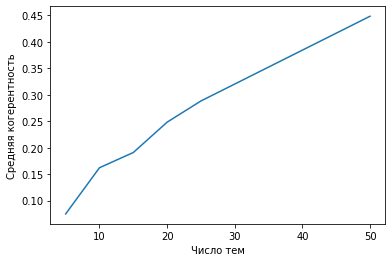

In [322]:
# попытка найти оптимальное количество тем
topics_list = [5, 10, 15, 20, 25, 50]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['prepr_text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [324]:
# обучение и просмотр результатов модели, обученной на 50 тем
lda_50 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=50, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_50, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Метрики для модели LDA на 50 тем

In [325]:
print('Персплексия: ', np.exp(lda_50.log_perplexity(corpus)))

Персплексия:  2.9056289950809803e-05


In [326]:
coherence_model_lda_50 = CoherenceModel(model=lda_50, texts=df['prepr_text'], dictionary=dictionary, coherence='c_v')
coherence_lda_50 = coherence_model_lda_50.get_coherence()
print('Средняя когерентность: ', coherence_lda_50)

Средняя когерентность:  0.4403928415834764


**С точки зрения человеческого суждения, разбиение твитов на темы в этом примере не дало понятного семантического разделения. В созданных моделью категориях сложно найти токены, объединённые единым смыслом. Большинство тем являются пересекающимися и при увеличении количества тем, пересечений становится значительно больше, но токены в темах не становятся очевидно более близкими по смыслу. И хотя когерентность растёт, предпологаю, что оптимальное количество тем - это большое число, требуещее больших временных ресурсов для обработки.**<br>
Возможно, результат модели можно считать плохим, но я думаю, что дело в характере самой выборки данных, зачастую не несущих определённой смысловой нагрузки

**Проверка результатов работы модели LDA из библиотеки BigARTM на тех же данных**

In [1]:
%%capture
# установка библиотеки ARTM 
!apt-get --yes update
!apt-get --yes install git make cmake build-essential libboost-all-dev
!apt-get --yes install python-numpy python-pandas python-scipy
!wget https://bootstrap.pypa.io/get-pip.py
!python get-pip.py
!pip install protobuf tqdm wheel
!git clone --branch=stable https://github.com/bigartm/bigartm.git
%cd bigartm
!mkdir build
%cd build
!cmake ..
!make
!make install
!pip install python/bigartm*.whl

In [2]:
import artm
# проверка успешного импорта
artm.version()

'0.10.0'

In [3]:
artm.ARTM(num_topics=10).info

config {
  topic_name: "topic_0"
  topic_name: "topic_1"
  topic_name: "topic_2"
  topic_name: "topic_3"
  topic_name: "topic_4"
  topic_name: "topic_5"
  topic_name: "topic_6"
  topic_name: "topic_7"
  topic_name: "topic_8"
  topic_name: "topic_9"
  score_config {
    name: "^^^ItemsProcessedScore^^^"
    type: ScoreType_ItemsProcessed
    config: ""
  }
  pwt_name: "pwt"
  nwt_name: "nwt"
  num_document_passes: 10
  reuse_theta: false
  cache_theta: false
}
score {
  name: "^^^ItemsProcessedScore^^^"
  type: "N4artm5score14ItemsProcessedE"
}
processor_queue_size: 0
num_processors: 2

Преобразование предобработанных данных в формат vowpal wabbit для модели

In [13]:
df['vw_text'] = df['prepr_text'].apply(lambda x: ' '.join(x))

In [23]:
def convert_to_vw_format(index, row):
    return f'doc{index} {row}'

In [25]:
with open('tweets_wv.wv', 'w') as f:
    for index, row in df.iterrows():
        vw_string = convert_to_vw_format(index, row['vw_text'])
        f.write(vw_string)
        f.write('\n')

In [26]:
# создание объекта BatchVectorizer
batch_vectorizer = artm.BatchVectorizer(data_path='tweets_wv.wv', 
                                        data_format='vowpal_wabbit',
                                        target_folder='tweets_batches')

In [27]:
%%time 
# обучение модели LDA на 10 тем
lda = artm.LDA(num_topics=10, alpha=0.1, beta=0.001, 
               cache_theta=True,
               num_document_passes=5, 
               dictionary=batch_vectorizer.dictionary)

lda.fit_offline(batch_vectorizer=batch_vectorizer, 
                num_collection_passes=10)

CPU times: user 1min 11s, sys: 1.36 s, total: 1min 12s
Wall time: 46.2 s


In [28]:
# значения перплексии
lda.perplexity_value

[91048.3359375,
 5230.486328125,
 4442.38037109375,
 3952.964111328125,
 3654.1953125,
 3451.08642578125,
 3304.3642578125,
 3195.696533203125,
 3113.967041015625,
 3051.732177734375]

In [29]:
np.log(lda.perplexity_last_value)

8.023464635517906

In [30]:
# вывод тем с токенами
top_tokens = lda.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print ('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['любить', 'работа', 'так', 'первый', 'ходить', 'красивый', 'еда', 'ребята', 'интернет', 'пусть']
Topic #1: ['знать', 'завтра', 'я', 'дом', 'сегодня', 'видеть', 'нравиться', 'остаться', 'понимать', 'равно']
Topic #2: ['день', 'делать', 'хороший', 'вообще', 'утро', 'человек', 'настроение', 'идти', 'что', 'добрый']
Topic #3: ['новый', 'посмотреть', 'если', 'фотка', 'подарок', 'ненавидеть', 'столько', 'год', 'смочь', 'закончиться']
Topic #4: ['жизнь', 'купить', 'читать', 'мой', 'нужный', 'вечер', 'таки', 'помнить', 'твиттер', 'наверное']
Topic #5: ['такой', 'это', 'один', 'прийти', 'давать', 'вот', 'надеяться', 'жаль', 'сон', 'наш']
Topic #6: ['хотеть', 'блин', 'думать', 'сидеть', 'писать', 'скучать', 'плохо', 'стать', 'вопрос', 'любовь']
Topic #7: ['смотреть', 'спать', 'друг', 'говорить', 'пойти', 'забыть', 'снег', 'жить', 'твой', 'пара']
Topic #8: ['мочь', 'школа', 'написать', 'болеть', 'мама', 'понять', 'ночь', 'последний', 'фильм', 'ахи']
Topic #9: ['мой', 'любимый', 'самый'

In [38]:
# вывод тем с токенами и весами
top_tokens = lda.get_top_tokens(num_tokens=10, with_weights=True)
for i, token_list in enumerate(top_tokens):
     print ('Topic #{0}: {1}'.format(i, token_list))

Topic #0: [('любить', 0.043400838971138), ('работа', 0.01888997294008732), ('так', 0.015884490683674812), ('первый', 0.013031525537371635), ('ходить', 0.00823073647916317), ('красивый', 0.008128290995955467), ('еда', 0.007843312807381153), ('ребята', 0.007317667361348867), ('интернет', 0.006298646796494722), ('пусть', 0.0062688481993973255)]
Topic #1: [('знать', 0.04961080849170685), ('завтра', 0.03014913573861122), ('я', 0.02312811277806759), ('дом', 0.022256193682551384), ('сегодня', 0.01706618443131447), ('видеть', 0.0161651149392128), ('нравиться', 0.013999090529978275), ('остаться', 0.013016320765018463), ('понимать', 0.010625065304338932), ('равно', 0.010562386363744736)]
Topic #2: [('день', 0.03211496025323868), ('делать', 0.031054317951202393), ('хороший', 0.028891095891594887), ('вообще', 0.026178423315286636), ('утро', 0.02274908311665058), ('человек', 0.022328587248921394), ('настроение', 0.020413590595126152), ('идти', 0.020365677773952484), ('что', 0.01770775392651558), ('

И снова нельзя сказать, что токены внутри тем каким-то очевидным образом принадлежат к какойто-определённой смысловой группе. Можно найти некоторе сходство с результатами работы первой LDA модели из библиотеки gensim